In [1]:
import numpy as np
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPool2D
from keras.datasets import cifar10
from keras.applications.vgg16 import VGG16
from keras.applications.nasnet import NASNetMobile
from keras.applications.mobilenet import MobileNet
from keras.utils import np_utils
import matplotlib.pyplot as plt
from pandas import DataFrame

%matplotlib inline

Using TensorFlow backend.


## Load Data

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

[7]


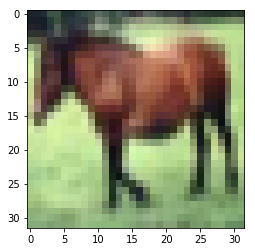

In [3]:
print(y_train[7])   #Convince yourself that the labels are consistent with the data.  See https://www.cs.toronto.edu/~kriz/cifar.html
plt.imshow(x_train[7,:,:,:])

## Clean Data

In [4]:
x_train_unrolled = x_train.reshape(-1,32*32*3) / 256
print(x_train_unrolled.shape)
y_train_encoded = np_utils.to_categorical(y_train)

x_test_unrolled = x_test.reshape(-1,32*32*3) / 256
y_test_encoded = np_utils.to_categorical(y_test)

(50000, 3072)


## Load Existing Neural Net

In [7]:
fresh = MobileNet(include_top = False, weights=None)
#fresh.summary()

In [8]:
%%time
rand_init_model = Sequential()

rand_init_model.add(Dense(64,input_dim=(32*32*3), activation = 'sigmoid',name='cifar10_in_adapter'))
rand_init_model.layers.extend(fresh.layers[1:])
rand_init_model.add(Dense(10,activation = 'softmax', name='cifar10_class_adapter'))

rand_init_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history_fresh = rand_init_model.fit(x_train_unrolled,y_train_encoded, epochs=3, batch_size = 4)



Epoch 1/3
50000/50000 [==============================] - 80s 2ms/step - loss: 2.0071 - acc: 0.2649
Epoch 2/3
50000/50000 [==============================] - 76s 2ms/step - loss: 1.9210 - acc: 0.3053
Epoch 3/3
50000/50000 [==============================] - 78s 2ms/step - loss: 1.8893 - acc: 0.3183


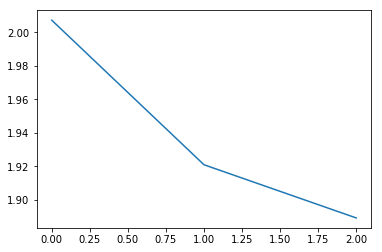

In [9]:
plt.plot(history_fresh.history['loss'])
#plt.plot(history_fresh.history['acc'])

In [10]:
#Documentation for MobileNet says smaller shapes allowed, but throws error.  https://keras.io/applications/#mobilenet
#Thus, we have to adapt a new model to take the dimensions of our data (32,32,3).
#Initializing w/ input_shape will create input layer which we will later remove.  
trained_model = MobileNet(input_shape = (128,128,3),include_top = False, weights='imagenet')

#Freeze: keep pre-trained weights as they are, we are transfer learning for a reason!
for layer in trained_model.layers:
    layer.trainable = False

#Check number of trainable parameters.
#trained_model.summary()

In [11]:



#Create new model to add the trained model into.  
transfer_model = Sequential()
transfer_model.add(Dense(64,input_dim=(32*32*3), activation = 'sigmoid',name='cifar10_in_adapter'))
    
    
#Extend list of layers to include layers of trained_model, except for the first input layer.
#Check summary on model to see the layer structures.
#Remember, include_top = False has already chopped off the classification layers.
transfer_model.layers.extend(trained_model.layers[1:])
transfer_model.add(Dense(10, activation = 'softmax', name = 'cifar10_class_adapter'))

#Experiment: freeze all trainable params.  What do you expect to happen to the acc?  Check summary.
#transfer_model.trainable = False  


transfer_model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics=['accuracy'])


CPU times: user 65 ms, sys: 1.67 ms, total: 66.7 ms
Wall time: 66.9 ms


In [13]:
transfer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cifar10_in_adapter (Dense)   (None, 64)                196672    
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 130, 130, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 66, 66, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
__________

## Fit

In [12]:
%%time
history_transfer = transfer_model.fit(x_train_unrolled,y_train_encoded,epochs=5,batch_size=4)

Epoch 1/5
50000/50000 [==============================] - 63s 1ms/step - loss: 2.0055 - acc: 0.2660
Epoch 2/5
50000/50000 [==============================] - 63s 1ms/step - loss: 1.9130 - acc: 0.3065
Epoch 3/5
50000/50000 [==============================] - 66s 1ms/step - loss: 1.8895 - acc: 0.3162
Epoch 4/5
50000/50000 [==============================] - 64s 1ms/step - loss: 1.8758 - acc: 0.3244
Epoch 5/5
50000/50000 [==============================] - 65s 1ms/step - loss: 1.8764 - acc: 0.3199
CPU times: user 10min 19s, sys: 1min 51s, total: 12min 11s
Wall time: 5min 21s


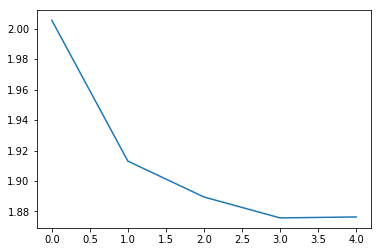

In [14]:
plt.plot(history_transfer.history['loss'])